In [1]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import os
import cv2
import random
import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
os.environ['TFF_CPP_MIN_LOG_LEVEL'] = '2'

%matplotlib inline

In [2]:
DATA_DIR = 'E:/Dataset'
TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'training_set')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'test_set')

In [3]:
IMG_SIZE = 32
CATEGORIES = []

for i in os.listdir(TRAIN_DATA_DIR):
    CATEGORIES.append(i)
    
print(CATEGORIES)

['cats', 'dogs']


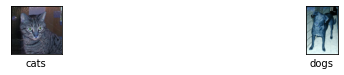

In [4]:
plt.figure(figsize=(20,10))
i=0
for c in CATEGORIES:  
    path = os.path.join(TRAIN_DATA_DIR,c)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.subplot(10,5,i+1)
        plt.imshow(img_array)
        plt.xlabel(c)
        plt.xticks([])
        plt.yticks([])
        i += 1
        break

plt.tight_layout()        
plt.show()

In [5]:
training_data = []

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c) 
    class_num = CATEGORIES.index(c) # 0
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img)) 
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) 
            training_data.append([img_resized, class_num])
        except Exception as e:
            pass
        
print(len(training_data))

100%|██████████| 4006/4006 [00:06<00:00, 659.38it/s]

8005


In [6]:

test_data = []

for c in CATEGORIES:
    path = os.path.join(TEST_DATA_DIR, c) 
    class_num = CATEGORIES.index(c) 
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))   
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
            test_data.append([img_resized, class_num])
        except Exception as e:
            pass
        
print(len(test_data))

100%|██████████| 1013/1013 [00:01<00:00, 630.48it/s]

2023


In [7]:
random.shuffle(training_data)
random.shuffle(test_data)

In [8]:
X_train = []
Y_train = []

for img, label in training_data:
    X_train.append(img)
    Y_train.append(label)
    
X_train = np.array(X_train).astype('float32').reshape(-1,IMG_SIZE,IMG_SIZE,3)
Y_train = np.array(Y_train)

print(f"X_train= {X_train.shape} Y_train= {Y_train.shape}")

X_train= (8005, 32, 32, 3) Y_train= (8005,)


In [9]:
X_test = []
Y_test = []

for features,label in test_data:
    X_test.append(features)
    Y_test.append(label)

X_test = np.array(X_test).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_test = np.array(Y_test)

print(f"X_test= {X_test.shape} Y_test= {Y_test.shape}")

X_test= (2023, 32, 32, 3) Y_test= (2023,)


In [10]:
mean_rgb = np.mean(X_train, axis=(0,1,2))
print(mean_rgb)

[106.21068 115.8426  124.38356]


In [11]:
X_train_norm = np.empty_like(X_train)
X_test_norm = np.empty_like(X_test)

In [12]:
for i in range(len(X_train)):
    for c in range(3):
        if(c==1):
            X_train_norm[i,:, :, c] = X_train[i,:, :, c] - mean_rgb[0]
        elif(c==2):
            X_train_norm[i,:, :, c] = X_train[i,:, :, c] - mean_rgb[1]
        else:
            X_train_norm[i,:, :, c] = X_train[i,:, :, c] - mean_rgb[2]
            
for i in range(len(X_test)):
    for c in range(3):
        if(c==1):
            X_test_norm[i,:, :, c] = X_test[i,:, :, c] - mean_rgb[0]
        elif(c==2):
            X_test_norm[i,:, :, c] = X_test[i,:, :, c] - mean_rgb[1]
        else:
            X_test_norm[i,:, :, c] = X_test[i,:, :, c] - mean_rgb[2]

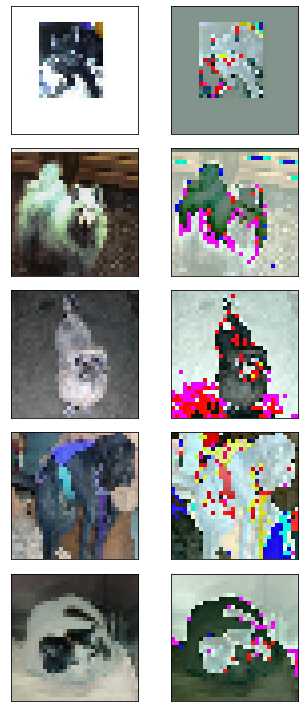

In [13]:
c = 0
plt.figure(figsize=(5,10))
for i in range(5):
    plt.subplot(5,2,c+1)
    plt.imshow(X_train[i].astype('uint8'))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(5,2,c+2)
    plt.imshow(X_train_norm[i].astype('uint8'))
    plt.xticks([])
    plt.yticks([])

    c += 2
    
plt.tight_layout()
plt.show()

In [14]:
model = keras.Sequential([
    ## input layer
    keras.Input(shape=X_train_norm.shape[1:]),
    
    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    
    
    
    
    
    layers.Flatten(),
    
    layers.Dense(units=256),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    
    layers.Dense(units=256),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(10),
    layers.Activation('softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2

In [15]:

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [16]:
cb = EarlyStopping(monitor='val_loss', min_delta=0.02, patience=3, restore_best_weights=True)

h = model.fit(x=X_train_norm, y=Y_train, 
              epochs=100, 
              validation_split=0.2,
              batch_size=128,
              callbacks=[cb]
             )

Epoch 1/100
51/51 [==============================] - 10s 33ms/step - loss: 6.6704 - accuracy: 0.4307 - val_loss: 1.0343 - val_accuracy: 0.5428
Epoch 2/100
51/51 [==============================] - 1s 11ms/step - loss: 1.7472 - accuracy: 0.4275 - val_loss: 0.9336 - val_accuracy: 0.5340
Epoch 3/100
51/51 [==============================] - 1s 11ms/step - loss: 1.5393 - accuracy: 0.4667 - val_loss: 0.8178 - val_accuracy: 0.5572
Epoch 4/100
51/51 [==============================] - 1s 11ms/step - loss: 1.4086 - accuracy: 0.5022 - val_loss: 0.8250 - val_accuracy: 0.5628
Epoch 5/100
51/51 [==============================] - 1s 11ms/step - loss: 1.3140 - accuracy: 0.5187 - val_loss: 0.8214 - val_accuracy: 0.5884
Epoch 6/100
51/51 [==============================] - 1s 11ms/step - loss: 1.2681 - accuracy: 0.5206 - val_loss: 0.7304 - val_accuracy: 0.6115
Epoch 7/100
51/51 [==============================] - 1s 11ms/step - loss: 1.2188 - accuracy: 0.5395 - val_loss: 0.7291 - val_accuracy: 0.6102
Epoch

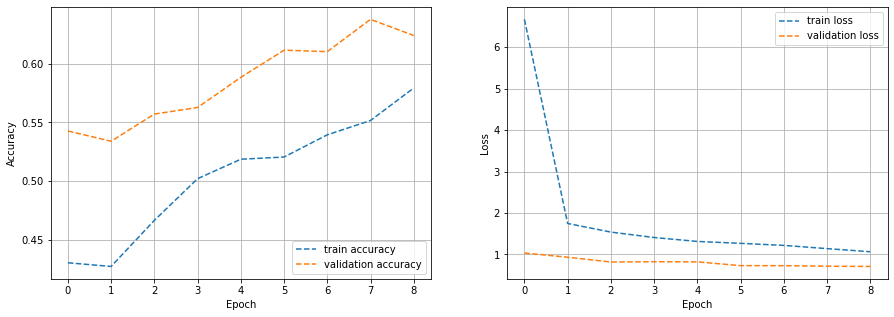

In [17]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'], '--', label='train accuracy')
plt.plot(h.history['val_accuracy'], '--', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'], '--', label='train loss')
plt.plot(h.history['val_loss'], '--', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

In [19]:
model.save('./resources/data/my_vgg.h5')

In [20]:
from tensorflow.keras.models import load_model

In [21]:
vgg_model = load_model('./resources/data/my_vgg.h5')

In [22]:
vgg_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2

In [23]:
test_loss, test_acc = vgg_model.evaluate(X_test_norm, Y_test)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)

64/64 [==============================] - 0s 3ms/step - loss: 0.7212 - accuracy: 0.6090

Test Accuracy: 0.6089965105056763

Test Loss: 0.7211874127388
